# [Neural CDE](https://docs.kidger.site/diffrax/examples/neural_cde/)
Neural CDE は次のような式で表現されるモデルである。

$$y(t) = y(0) + \int_0^t f_\theta(y(s)) \frac{\mathrm{d}x}{\mathrm{d}s}(s) \mathrm{d}s$$

ここでは、 Neural CDE を用いて時計回りの渦と、反時計回りの渦の分類を行う。

In [5]:
import math
import time
from typing import Sequence, Tuple, Union, Callable, Optional

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
from jaxtyping import Array, Float, PRNGKeyArray
import matplotlib
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

from tools._dataset.datasets import SpiralDataset
from tools._dataset.dataloader import dataloader
from tools._model.neural_cde import NeuralCDE
from tools._loss.cross_entropy import bce_loss, nll_loss

## ベクトル場
`01_controlled_differential_equations` と同様に、まずはベクトル場を定義する。今回は未知の真なるベクトル場を Neural Network で近似する。

`equinox.nn.MLP` では、入力層のノード数 `in_size`、中間層のノード数 `width_size`、出力層のノード数 `out_size`、さらに層数 `depth` を指定することで、MLPを初期化できる。また `activation` は各中間層につける活性化関数、 `final_activation` は出力層につける活性化関数を指定するための引数である。

ベクトル場は $f_\theta: \mathbb{R}^{d_y} \rightarrow \mathbb{R}^{d_y \times d_x}$ で与えられるものなので、入力サイズは `hidden_size` で、出力サイズ `hidden_size * in_size` となっている。（`in_size` = $d_x$, `hidden_size` = $d_y$）

class Func(eqx.Module):
    """
        ベクトル場を定義.
    """
    mlp: eqx.nn.MLP
    in_size: int
    hidden_size: int

    def __init__(self, in_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * in_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t: Optional[Array], y: Array, args: Optional[Array] = None):
        return self.mlp(y).reshape(self.hidden_size, self.in_size)

## Neural CDE
Neural CDE モデルを定義している.

class NeuralCDE(eqx.Module):
    """
        Neural CDE モデルを定義.
    """
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, in_size, out_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3) # 乱数生成キーを分割し, 独立した新たなキーを作成
        self.initial = eqx.nn.MLP(in_size, hidden_size, width_size, depth, key=ikey) # 初期条件のモデルを初期化
        self.func = Func(in_size, hidden_size, width_size, depth, key=fkey) # ベクトル場のモデルを初期化
        self.linear = eqx.nn.Linear(hidden_size, out_size, key=lkey) # 出力層のモデルを初期化

    def __call__(self, ts, coeffs, evolving_out=False):
        # Each sample of data consists of some timestamps `ts`, and some `coeffs`
        # parameterising a control path. These are used to produce a continuous-time
        # input path `control`.
        control = diffrax.CubicInterpolation(ts, coeffs) # 制御信号（パス）の生成
        term = diffrax.ControlTerm(self.func, control).to_ode() # Term の生成
        solver = diffrax.Tsit5() # ソルバー
        dt0 = None # 最初のステップに使用するステップサイズ
        y0 = self.initial(control.evaluate(ts[0])) # 積分区間の始点
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=saveat,
        ) # 微分方程式の解を計算
        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.sigmoid(self.linear(y))[0])(solution.ys)
        else:
            (prediction,) = jnn.sigmoid(self.linear(solution.ys[-1]))
        return prediction

# Train and Eval

In [6]:
def main(
    dataset_size=4096,
    length=100,
    out_size=1,
    add_noise=False,
    batch_size=32,
    lr=3e-3,
    steps=100,
    hidden_size=8,
    width_size=128,
    depth=1,
    seed=5678,
):
    key = jr.PRNGKey(seed)
    train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

    dataset = SpiralDataset(dataset_size, length, add_noise, key=train_data_key)
    ts, _, coeffs, labels, in_size = dataset.make_dataset()
    
    model = NeuralCDE(in_size, out_size, hidden_size, width_size, depth, key=model_key)

    # Training loop like normal.

    grad_loss = eqx.filter_value_and_grad(bce_loss, has_aux=True)

    @eqx.filter_jit
    def make_step(model: eqx.Module, data: Array, opt_state: Tuple, *args, key:PRNGKeyArray) -> Tuple[Float, Float, eqx.Module, Tuple]:
        ts, labels, *coeffs = data
        (bxe, acc), grads = grad_loss(model, (ts, coeffs), labels, *args, key=key)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return bxe, acc, model, opt_state

    model = eqx.nn.inference_mode(model, value=False)
    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    loader_key, _loader_key = jr.split(loader_key, 2)
    for step, data in zip(
        range(steps), dataloader((ts, labels) + coeffs, batch_size, key=_loader_key)
    ):
        loader_key, _loader_key = jr.split(loader_key, 2)
        start = time.time()
        bxe, acc, model, opt_state = make_step(model, data, opt_state, key=_loader_key)
        end = time.time()
        print(
            f"Step: {step}, Loss: {bxe}, Accuracy: {acc}, Computation time: "
            f"{end - start}"
        )

    model = eqx.nn.inference_mode(model)
    test_data_key, inference_key = jr.split(test_data_key, 2)
    dataset = SpiralDataset(dataset_size, length, add_noise, key=test_data_key)
    ts, _, coeffs, labels, _ = dataset.make_dataset()
    bxe, acc = bce_loss(model, (ts, coeffs), labels, key=inference_key)
    print(f"Test loss: {bxe}, Test Accuracy: {acc}")

    # Plot results
    sample_ts = ts[-1]
    sample_coeffs = tuple(c[-1] for c in coeffs)
    pred = model(sample_ts, sample_coeffs, evolving_out=True)
    interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
    values = jax.vmap(interp.evaluate)(sample_ts)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
    ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
    ax1.plot(sample_ts, pred, c="crimson", label="Classification")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel("t")
    ax1.legend()
    ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
    ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("Classification")
    plt.tight_layout()
    plt.savefig("./figures/neural_cde.png")
    plt.show()

Step: 0, Loss: 2.794525384902954, Accuracy: 0.46875, Computation time: 2.312623977661133
Step: 1, Loss: 0.673264741897583, Accuracy: 0.6875, Computation time: 0.09139299392700195
Step: 2, Loss: 1.3014707565307617, Accuracy: 0.5, Computation time: 0.1000211238861084
Step: 3, Loss: 0.7766721844673157, Accuracy: 0.53125, Computation time: 0.08306002616882324
Step: 4, Loss: 0.567244827747345, Accuracy: 0.5, Computation time: 0.07581591606140137
Step: 5, Loss: 0.8513493537902832, Accuracy: 0.4375, Computation time: 0.07546496391296387
Step: 6, Loss: 0.6795979738235474, Accuracy: 0.46875, Computation time: 0.07922911643981934
Step: 7, Loss: 0.47527897357940674, Accuracy: 0.9375, Computation time: 0.08021926879882812
Step: 8, Loss: 0.44102025032043457, Accuracy: 0.96875, Computation time: 0.09631896018981934
Step: 9, Loss: 0.5183666348457336, Accuracy: 0.5, Computation time: 0.10269689559936523
Step: 10, Loss: 0.49918133020401, Accuracy: 0.59375, Computation time: 0.0990908145904541
Step: 11,

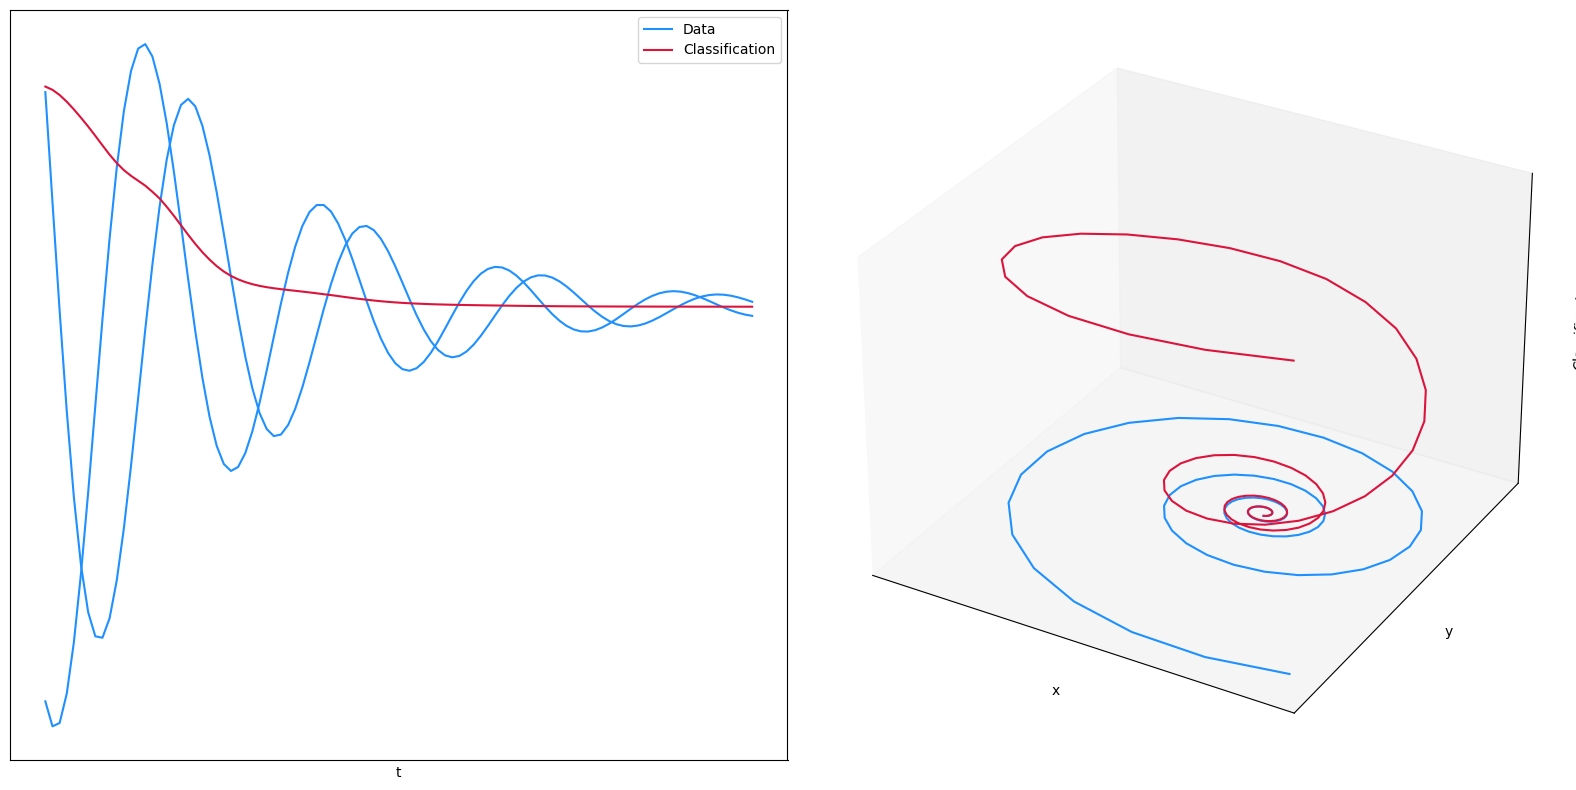

In [7]:
main()

In [8]:
def main(
    dataset_size=4096,
    length=100,
    out_size=2,
    add_noise=False,
    batch_size=32,
    lr=3e-3,
    steps=100,
    hidden_size=8,
    width_size=128,
    depth=1,
    seed=5678,
):
    key = jr.PRNGKey(seed)
    train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

    dataset = SpiralDataset(dataset_size, length, add_noise, key=train_data_key)
    ts, _, coeffs, labels, in_size = dataset.make_dataset()
    
    model = NeuralCDE(in_size, out_size, hidden_size, width_size, depth, key=model_key)

    # Training loop like normal.

    grad_loss = eqx.filter_value_and_grad(nll_loss, has_aux=True)

    @eqx.filter_jit
    def make_step(model: eqx.Module, data: Array, opt_state: Tuple, *args, key:PRNGKeyArray) -> Tuple[Float, Float, eqx.Module, Tuple]:
        ts, labels, *coeffs = data
        (xe, acc), grads = grad_loss(model, (ts, coeffs), labels, *args, key=key)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return xe, acc, model, opt_state

    model = eqx.nn.inference_mode(model, value=False)
    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    loader_key, _loader_key = jr.split(loader_key, 2)
    for step, data in zip(
        range(steps), dataloader((ts, labels) + coeffs, batch_size, key=_loader_key)
    ):
        loader_key, _loader_key = jr.split(loader_key, 2)
        start = time.time()
        xe, acc, model, opt_state = make_step(model, data, opt_state, out_size, key=_loader_key)
        end = time.time()
        print(
            f"Step: {step}, Loss: {xe}, Accuracy: {acc}, Computation time: "
            f"{end - start}"
        )

    model = eqx.nn.inference_mode(model)
    test_data_key, inference_key = jr.split(test_data_key, 2)
    dataset = SpiralDataset(dataset_size, length, add_noise, key=test_data_key)
    ts, _, coeffs, labels, _ = dataset.make_dataset()
    xe, acc = nll_loss(model, (ts, coeffs), labels, out_size, key=inference_key)
    print(f"Test loss: {xe}, Test Accuracy: {acc}")

    # Plot results
    sample_ts = ts[-1]
    sample_coeffs = tuple(c[-1] for c in coeffs)
    pred = model(sample_ts, sample_coeffs, evolving_out=True)
    interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
    values = jax.vmap(interp.evaluate)(sample_ts)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
    ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
    ax1.plot(sample_ts, pred, c="crimson", label="Classification")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel("t")
    ax1.legend()
    ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
    ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("Classification")
    plt.tight_layout()
    plt.savefig("./figures/neural_cde.png")
    plt.show()

Step: 0, Loss: 2.1475884914398193, Accuracy: 0.46875, Computation time: 1.9683277606964111
Step: 1, Loss: 0.7085868120193481, Accuracy: 0.6875, Computation time: 0.0854036808013916
Step: 2, Loss: 1.2602276802062988, Accuracy: 0.5, Computation time: 0.08088898658752441
Step: 3, Loss: 0.8377551436424255, Accuracy: 0.53125, Computation time: 0.10183119773864746
Step: 4, Loss: 0.5996435880661011, Accuracy: 0.71875, Computation time: 0.0901341438293457
Step: 5, Loss: 0.8738760948181152, Accuracy: 0.4375, Computation time: 0.10541582107543945
Step: 6, Loss: 0.7150586247444153, Accuracy: 0.46875, Computation time: 0.09775996208190918
Step: 7, Loss: 0.6029584407806396, Accuracy: 0.84375, Computation time: 0.08402299880981445
Step: 8, Loss: 0.6900551915168762, Accuracy: 0.46875, Computation time: 0.09919500350952148
Step: 9, Loss: 0.6646190881729126, Accuracy: 0.5, Computation time: 0.09114718437194824
Step: 10, Loss: 0.6093526482582092, Accuracy: 0.625, Computation time: 0.09635090827941895
St

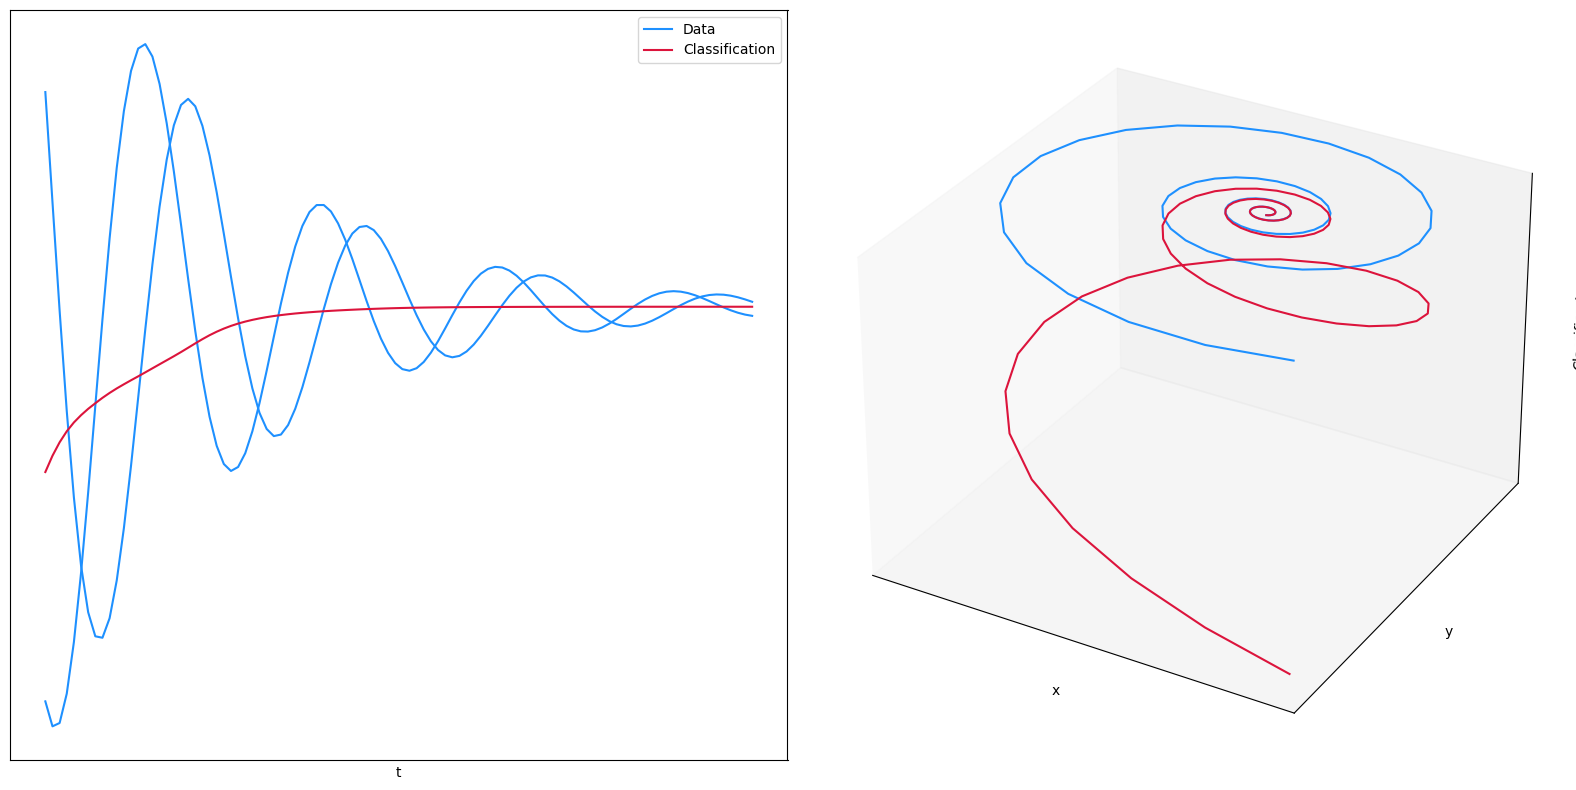

In [9]:
main()